<a href="https://colab.research.google.com/github/Tamar-m/RAVIR/blob/main/RAVIR_DinoV2_Segformer_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 129.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.6 MB/s eta 0:00:00


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
import pandas as pd
import cv2
import numpy as np
import albumentations as aug
import requests
import h5py
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor,SegformerDecodeHead, AutoModel, SegformerModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = './drive/MyDrive/Deep Learning Class/RAVIR'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# test return hidden states of segformer output
model = SegformerModel.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

In [ ]:
# # load the DinoV2 model (Large model, there is one larger- maybe better)
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# model.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


KeyboardInterrupt: ignored

In [ ]:
# #Extract features and save to folder in drive using dinov2

# transform1 = transforms.Compose([
#                                 transforms.ToTensor(),
#                                 transforms.Pad(1,0), #pad the images to match model patch size
#                                 transforms.Resize([924,924]),
#                                 transforms.Normalize(mean=0.5, std=0.2)
#                                 ])



# patch_size = model.patch_size # patchsize=14

# # 520//14
# # 768?
# # patch_h  = 518//patch_size
# # patch_w  = 518//patch_size

# patch_h  = 924//patch_size
# patch_w  = 924//patch_size

# print(patch_h)
# print(patch_w)

# # feat_dim = 384 # vits14
# # feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
# #feat_dim = 1536 # vitg14

# folder_path = os.path.join(root_dir,"test","images")
# total_features  = []
# with torch.no_grad():
#   for img_name in os.listdir(folder_path):
#     img_path = os.path.join(folder_path, img_name)
#     img = Image.open(img_path).convert('RGB')
#     img_t = transform1(img)
#     pixel_values = img_t.unsqueeze(0).to(device)
#     features_dict = model.forward_features(pixel_values)
#     features = features_dict['x_norm_patchtokens']
#     features.shape
#     torch.save(features, os.path.join(root_dir,"test","feature_maps",os.path.splitext(img_name)[0]+'.pt'))
#     total_features.append(features)

# total_features = torch.cat(total_features, dim=0)
# total_features.shape

66
66


torch.Size([19, 4356, 1024])

In [ ]:
# total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim)
# total_features.shape

torch.Size([16900, 1024])

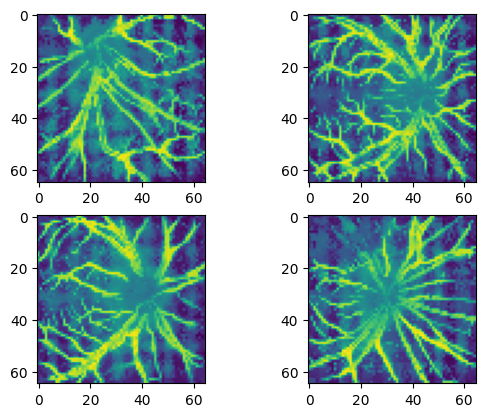

In [ ]:
# # display the PCA of the calculated features
# pca = PCA(n_components=3)
# pca.fit(total_features.cpu())
# pca_features = pca.transform(total_features.cpu())

# # min_max scale
# pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
#                      (pca_features[:, 0].max() - pca_features[:, 0].min())
# #pca_features = sklearn.processing.minmax_scale(pca_features)

# for i in range(4):
#     plt.subplot(2, 2, i+1)
#     plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

# plt.show()


In [ ]:
label2id = {"Background":0,"Artery":1,"Vein":2}
id2label = {v: k for k, v in label2id.items()}

In [ ]:
class conv_head(nn.Module):
    def __init__(self, in_channels=1024, out_channels=3):
        super(conv_head, self).__init__()
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels, 256, kernel_size=4, stride=4, padding=0)  # Output: (4, 256, 128, 128)
        self.conv_transpose2 = nn.ConvTranspose2d(256, out_channels, kernel_size=4, stride=4, padding=0)  # Output: (4, 3, 448, 448)

    def forward(self, x):
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        return x

class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=3):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)


class Segmentor(nn.Module):
    def __init__(self, num_classes=3, embedding_size=1024, head = 'conv'):
        super(Segmentor, self).__init__()

        self.upsample = nn.Upsample(size = (448,448), mode = 'bilinear')
        self.backbone = AutoModel.from_pretrained('facebook/dinov2-large')
        self.backbone.eval()
        for param in self.backbone.parameters():
            param.requires_grad = False  # Freeze the backbone's parameters
        self.num_classes =  num_classes # add a class for background if needed
        self.embedding_size = embedding_size
        self.patch_size = self.backbone.patch_size
        self.conv = nn.ConvTranspose2d(self.embedding_size, 2, kernel_size=4, stride=1)  # Output: (batch_size, 2, 256, 256)
        #self.conv = nn.ConvTranspose2d(self.embedding_size, 3, kernel_size=4, stride=2, padding=1) # Output: (4, 1024, 64, 64)
        #self.conv = nn.ConvTranspose2d(self.embedding_size, 3, kernel_size=4, stride=2, padding=1)# Output: (4, 1024, 63, 63)
        self.segmentation_conv = nn.Conv2d(384, self.num_classes, kernel_size=1)
        self.upsample_features = nn.Upsample(size = (63,63), mode = 'bilinear')
        self.segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

    def forward(self, x):

        x_identity = x
        x = self.upsample(x)
        batch_size = x.shape[0]
        mask_dim = (x.shape[2] / self.patch_size, x.shape[3] / self.patch_size)
        with torch.no_grad():
            x = self.backbone.forward_features(x.cuda())
            x = x['x_norm_patchtokens']
            x = x.permute(0,2,1)
            x = x.reshape(batch_size,self.embedding_size,int(mask_dim[0]),int(mask_dim[1]))
        x = self.conv(x)
        x = torch.cat((x,y_identity),1)
        #x = self.upsample_features(x)
        x = self.segformer(x)
        return x

In [ ]:
model = Segmentor(num_classes=3, embedding_size=1024, head='conv')

KeyError: ignored

In [ ]:
def train_model(model, train_dataset, num_epochs, batch_size, learning_rate, device):
    model.to(device)
    model.train()  # Set the model to training mode

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader to load the data in batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    pbar = tqdm(train_loader)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for idx, batch in enumerate(pbar):
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(inputs)
            upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits # upsampled_logits.argmax(dim=1)


            # Compute the loss
            loss = criterion(predicted, labels)

            # Zero the gradients, backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate and print average loss for the epoch
        average_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    print("Training completed.")

In [ ]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path,"images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "mask")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        # read annotations
        annotation_file_names = []

        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        segmentation_map[segmentation_map==128]=1 # the loss in the segformer network only works of the labels are 0,1,2,3,...
        segmentation_map[segmentation_map==255]=2

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")


        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
train_transform = aug.Compose([
    aug.Flip(p=0.5),
    aug.RandomCrop(width=256, height=256),
    aug.RandomBrightnessContrast(p=0.2),
    aug.SafeRotate(p=0.5),
    #aug.Resize(448, 448, interpolation=1, always_apply=True, p=1)
])

transform_val = aug.Compose([
    aug.RandomCrop(width=256, height=256),
    #aug.Resize(448, 448, interpolation=1, always_apply=True, p=1)
])


feature_extractor = SegformerImageProcessor(do_resize=False,align=False, reduce_zero_label=False,do_normalize = False)
train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=train_transform, train=True)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform_val, train=False)

In [ ]:
train_model(model, train_dataset, num_epochs=100, batch_size=4, learning_rate=0.0008, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.8523
Epoch [2/100], Loss: 0.5936
Epoch [3/100], Loss: 0.4677
Epoch [4/100], Loss: 0.3442
Epoch [5/100], Loss: 0.4927
Epoch [6/100], Loss: 0.4223
Epoch [7/100], Loss: 0.3923
Epoch [8/100], Loss: 0.3691
Epoch [9/100], Loss: 0.3423
Epoch [10/100], Loss: 0.3280
Epoch [11/100], Loss: 0.3213
Epoch [12/100], Loss: 0.3129
Epoch [13/100], Loss: 0.2835
Epoch [14/100], Loss: 0.3049
Epoch [15/100], Loss: 0.3764
Epoch [16/100], Loss: 0.2671
Epoch [17/100], Loss: 0.2764
Epoch [18/100], Loss: 0.3349
Epoch [19/100], Loss: 0.2795
Epoch [20/100], Loss: 0.3017
Epoch [21/100], Loss: 0.3811
Epoch [22/100], Loss: 0.2926
Epoch [23/100], Loss: 0.2834
Epoch [24/100], Loss: 0.3340
Epoch [25/100], Loss: 0.2824
Epoch [26/100], Loss: 0.3605
Epoch [27/100], Loss: 0.3300
Epoch [28/100], Loss: 0.3108
Epoch [29/100], Loss: 0.2722
Epoch [30/100], Loss: 0.3246
Epoch [31/100], Loss: 0.3509
Epoch [32/100], Loss: 0.3094
Epoch [33/100], Loss: 0.2972
Epoch [34/100], Loss: 0.2840
Epoch [35/100], Loss: 0

torch.Size([4, 3, 63, 63])


<Figure size 640x480 with 0 Axes>

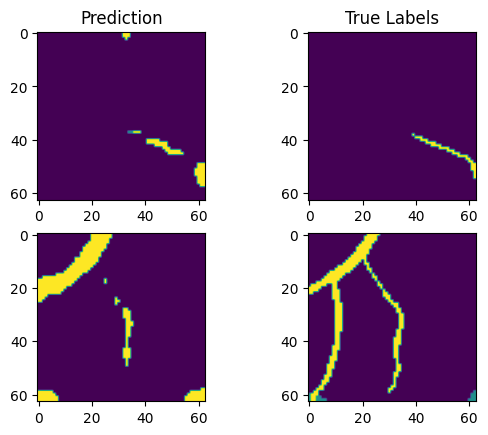

In [ ]:
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)
model.eval()
with torch.no_grad():
  for idx, batch in enumerate(valid_loader):
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(pixel_values)
      print(pixel_values.size())
      upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      mask = (labels != 0) # we don't include the background class in the accuracy calculation
      pred_labels = predicted[mask].detach().cpu().numpy()
      true_labels = labels[mask].detach().cpu().numpy()
      accuracy = accuracy_score(pred_labels, true_labels)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(predicted[0,:,:].detach().cpu().numpy())
axarr[0,0].title.set_text('Prediction')
axarr[0,1].imshow(labels[0,:,:].detach().cpu().numpy())
axarr[0,1].title.set_text('True Labels')
axarr[1,0].imshow(predicted[1,:,:].detach().cpu().numpy())
axarr[1,1].imshow(labels[1,:,:].detach().cpu().numpy())